# MPI LES with Nested Grids

The aim of this project is to allow higher time and space resolution on parts of the domain.

### STATUS 

- Nested LES works in two different modes: 
    * Uniform time step (see tag `uniform-timestep` in `devel` branch): the grid is stretched to provide higher spatial resolution. The simulation runs at the time step of the nested grid.
    * Different time step per grid region (aka 'proper' nesting): the nested part runs with a faster time step than the  original part. The time step ratio is the spatial ratio.
    
### TODO

- Use `MPI_Scatter` and `MPI_Gather`:
    - `anime`: 
        * subroutine `ifdata_out`: TODO
    - `aveflow`: 
        - TODO for all
    - `ifdata`:
        * subroutine `ifdata`: 
            - DONE for u,v,w,p; 
            - TODO for f,g,h,usum,vsum,wsum,fold,golf,hold
- Port `velFG` from the OpenCL version
- Create a nested version of the OpenCL code


## Nested versus piecewise constant 

Proper nesting means that for part of a domain, a finer grid is used than for the rest of the domain:             

```python
        if x_n_b < x < x_n_e and y_n_b < x < y_n_e:
                dx = DXN
                dy = DYN
        else:
                dx = DXP
                dy = DYP
```        

Piecewise constant means that for part of a domain, a finer grid is used than for the rest of the domain, but as follows:             

```python
            if x_n_b < x < x_n_e
                    dx = DXN
            else:
                    dx = DXP
            if y_n_b < x < y_n_e:        
                    dy = DYN
            else:
                    dy = DYP    
```        

The latter approach is much simpler but has some overhead:

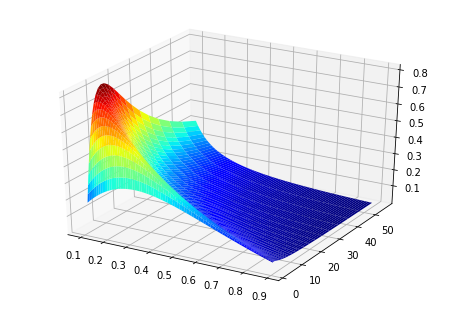

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy #as np
from matplotlib import cm
from matplotlib import pyplot as plt
alpha,kk = numpy.mgrid[0.1:0.9:0.01,1:6:.2]

k = 2**kk #)/numpy.log(2)
overhead = (2*alpha*(1-alpha)*(k-1))/(1+alpha*alpha*(k*k-1*0))

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(alpha,k,overhead,rstride=1,cstride=1,cmap=cm.jet)
plt.show()

The figure shows the overhead (additional fraction of grid points required) for the parameters $k$ and $\alpha$, respectively the increase in linear density of the nested grid compared to the original grid, and the linear ratio of the nested portion to the total domain. If we assume, without loss of generality, that the domain is square, and assuming the orginal resp nested domains have a linear size $m_0$ resp $m_1$ and linear grid point count of $k_0$ resp $k_1$ then the definitions for $k$ and $\alpha$ are:
$$
k = k_1 / k_0 \\
\alpha = m_1 / m_0
$$

For a typical case where the nested grid would e.g. be 50% of the linear size and have a 10x finer granularity, the overhead would be 17.3%:

In [35]:
def overhead(alpha,k):
    return 2*alpha*(1-alpha)*(k-1)/(1+alpha*alpha*(k*k-1*0))

alpha = 0.5
k = 10.0
print( 'Overhead: %2.1f%%' % ( 100*overhead(alpha,k) ))      

Overhead: 17.3%


### Actual overhead

For the actual use case, we have a `12km x 3km` outer domain and a `1km x 4km` inner domain. The outer domain has a resolution of `4m`, the inner `2m`. So we have:

In [36]:
def overhead_xy(alpha_x,alpha_y,k):
    return (alpha_x*(1-alpha_y)+alpha_x*(1-alpha_y))*(k-1)/(1+alpha_x*alpha_y*k*k)
m_0_x = 12
m_0_y = 3
m_1_x = 4
m_1_y = 1
k = 4/2
alpha_x = m_1_x/m_0_x
alpha_y = m_1_y/m_0_y
print( 'Overhead: %2.1f%%' % ( 100*overhead_xy(alpha_x,alpha_y,k))) 

Overhead: 30.8%


## Piecewise constant grid for the MPI LES

If we assume as a starting point a pwc grid for the MPI version of the LES, this simplifies the code a lot: the nested grid requires interpolation and therefore conditions on the boundaries with the nested subdomain. 

For a single grid, there are already 9 different conditions; with a nested grid, the total number of conditions would be 3*8+2 = 26 conditions.

The pwc grid only requires to set the grid spacing dependent on the MPI process: every process represents a sub-grid with identical dimensions. 

For example, if the original grid would be 300x300 and we replace the inner 1/3 with a 10x higher resolution, we obtain a 1200x1200 grid: 100 + 10x100 + 100 in each direction.

In general, if the original grid is $m_0 \times n_0$ and the nested grid is $m_1 \times n_1$, and the resolution increase is $k$, then the new grid size is 

$$
(m_0 - m_1) + k.m_1\;\times\;(n_0 - n_1) + k.n_1
$$

We can split this into 12x12 subgrids of 100x100. Then the subgrid spacing is determined by the subgrid coordinate:
```python
        if (i_s == 0 or i_s == 11): 
            j_sgs = dx
        else:
            i_sgs = dx/10
        if (j_s == 0 or j_s == 11): 
            j_sgs = dy
        else:
            j_sgs = dy/10
```

Or again generalised, assuming the nested grid is placed in the middle of the original domain:

$$
n_{s,i} = 2.((m_0 - m_1) + k.m_1) / (m_0 - m_1)\\
n_{s,j} = 2.((n_0 - n_1) + k.n_1) / (n_0 - n_1)
$$


The subgrid size in this case is

$$
m_s = ((m_0 - m_1) + k.m_1) / n_{s,i} = (m_0 - m_1) / 2\\
n_s = ((n_0 - n_1) + k.n_1) / n_{s,j} = (n_0 - n_1) / 2
$$

If the original grid spacing is $\Delta x$ then the grid spacing for the nested grid is $\Delta x/k$.


Every process is identified by its subgrid coordinates $i_s,j_s$ so that the pwc case only requires adapt the grid spacing for the process and the time step for the process based on the coordinates. 

### Grid spacing adaptation

This is a static operation: when the process starts, it populates the grid spacing arrays based on the subgrid coordinates. This is done in `grid.f95`

```fortran
        if (isMaster()) then
            do i=-1,(ip*procPerCol)+1
                dx1Tot(i) = dxgrid
            end do
        end if
        call distribute1DRealRowWiseArray(dx1Tot,dx1, 2, 1, procPerRow)
```

where `procPerCol` and `dxgrid` are defined in `params_common_sn.f95`, and similar for `dylTot`. So we need `dxgrid_orig` and `dxgrid_nest` in `params_common_sn.f95`.
Then we need to add a condition for the start and end of the nested grid:


```fortran
        if (isMaster()) then
            do i=-1,ip*procPerCol+1
                if (i>(nested_grid_start_x+2) .and. i<(nested_grid_end_x+2)) then
                    dx1Tot(i) = dxgrid_nest
                else
                    dx1Tot(i) = dxgrid_orig                
            end do
        end if
        call distribute1DRealRowWiseArray(dx1Tot,dx1, 2, 1, procPerRow)
```

And similar for the y-direction. The main issue here is the values of `nested_grid_start` and `nested_grid_stop`.
The nested grid is 2,003 points, the dx1Tot is 4003. The offset starting from `(1,1)` is `(251,276)`.
So 

```fortran
    nested_grid_x = 2000 ! 4km
    nested_grid_start_x = 251
    nested_grid_end_x  = nested_grid_x + nested_grid_start_x
    
    nested_grid_y = 500 ! 1km
    nested_grid_start_y = 276
    nested_grid_end_y  = nested_grid_y + nested_grid_start_y
    
```

Then we need to make sure any occurence of `dx1` uses `dx1Tot(i)` and of `dxl` uses  `dxlTot(i)`. We do this by determining `i` based on the rank of the process. This should be a simple array slice:

```fortran
    dx1_offset = i_s * ip
    dx1 = dx1Tot(-1+dx1_offset:ip+1+dx1_offset)
```

Actually, when considering this it is clear that we don't need `dx1Tot` and `dxlTot`. Instead, we can compute:


```fortran
            ! i_s is the subgrid coord
            do i=-1,ip+1
                ii = i_s*ip+i
                if (ii>nested_grid_start_x .and. ii< nested_grid_end_x) then
                    dx1(i) = dxgrid_nest
                else
                    dx1(i) = dxgrid_orig                
            end do
```

### Time step adaptation

This is a bit more tricky: given the subgrid coordinates we can easily and statically set the time step (`dt_orig` and `dt_nest`, to be defined in  `params_common_sn.f95`) in `set.f95` but it is a bit more complicated to do syncing.

For sending/receiving, we need to determine in which grid the source and the destination are.


If sender and receiver are both in the nested grid then sync on every time step `dt_nest` otherwise sync on every time step `dt_orig`. 

So if we have `n` ticks in the nest for 1 tick in the orig, then we need to count `n` ticks in the nest before we can send.
In other words, we need to have a counter in nest which gets reset on hitting `dt_orig`, and we sync either on the first or on the last step.

This also means that all calls that send/receive must have access to the tick. 

What we do is keep the tick constant for the orig domain and decrement for the nested domain. So, in the main timeloop, we do as follows:

```fortran        
        if (inNestedGrid()) then 
            ticks = ticks+1
            if (ticks == dt_nest/dt_orig) ticks = 0
        else
            ticks = 0
        end if
```        

So we need to change the subroutines `exchangeRealHalos` and `exchangeRealCorners` in `communication_helper_real` to include the tick, and predicate the sending/receiving on it. 

<!--
- To send from a process in the nested domain to a process in the orig domain only happens when `ticks == 0`.
- To send from a process in the nested domain to a process in the nested domain happens on all ticks
- To send from a process in the orig domain to a process in the nested domain happens on all ticks
- To send from a process in the orig domain to a process in the orig domain happens on all ticks

- To receive from a process in the orig domain by a process in the nested domain happens when `ticks == 0`
- To receive from a process in the nested domain by a process in the orig domain only happens on all ticks
- To receive from a process in the nested domain by a process in the nested domain happens on all ticks
- To receive from a process in the orig domain by a process in the orig domain happens on all ticks
-->

```fortran
        if (inNested() .and. .not. inNestedGridByRank(commWith) then
            if (ticks == 0) then
                    ! populate buffer
                    MPI_ISend(...)
                    MPI_IRecv(...)
            end if
        else
            MPI_ISend(...)/MPI_IRecv(...)
        end if     
```

#### What about `MPI_allreduce()` calls?

The `MPI_allreduce` call used in e.g. `getGlobalMaxOf` does not need syncing, so we don't need ticks. 

#### Subgrid coordinates

So the key question is: what about those subgrid coordinates? 

The LES code uses `procPerCol,procPerRow` and the grid in each proc is of size `ip,jp`. The identifier for each MPI process is `rank` and the total number of processes (the Master is just one of them) is `mpi_size` which I guess is 

        mpi_size = procPerCol*procPerRow
        
So the subgrid coordinates become:

```fortran
    subroutine calcSubgridCoords(procPerRow,rank,i_s,j_s) 
        integer, intent(In) :: procPerRow, rank
        integer, intent(Out) :: i_s,j_s
        i_s = rank / procPerRow ! => row, base 0
        j_s = rank % procPerRow !=> column, base 0
    end subroutine calcSubgridCoords    
```

Although actually I should use `MPI_Cart_coords`:

```fortran
    subroutine calcSubgridCoords(rank,i_s,j_s) 
        integer, intent(In) :: rank
        integer, intent(Out) :: i_s,j_s
        integer, dimension(2) :: ij_s
        integer :: ierr
        call MPI_Cart_coords(comm, rank, 2, ij_s, ierr)
        i_s = ij_s(1)
        j_s = ij_s(2)        
    end subroutine calcSubgridCoords    
```


Then we create a function `inNestedGrid()` which tells us which grid we're in for the current rank, and a function `inNestedGridByRank(rank)` for any rank.

To determine if a process with subgrid coordinates `(i_s,j_s)` is inside the nested grid, we define

```fortran
    i_s_nest_start = nested_grid_start_x / ip
    i_s_nest_end = i_s_nest_start + nested_grid_x / ip
    j_s_nest_start = nested_grid_start_y / ip
    j_s_nest_end = j_s_nest_start + nested_grid_y / ip     
```

```fortran
    pure logical function inNestedGridByRank(rank) result(in_grid)
            integer :: rank
            integer :: i_s, j_s
            call calcSubgridCoords(procPerRow,rank,i_s,j_s) 
            in_grid = i_s >= i_s_nest_start .and. is <= i_s_nest_end .and j_s >= j_s_nest_start .and. js <= j_s_nest_end
    end function inNestedGridByRank
```

```fortran
    pure logical function inNestedGrid() result(in_grid)
            in_grid = inNestedGridByRank(rank)
    end function inNestedGrid
```


This very easy for 2 grids. For more grids we need to number them and then have `inGrid()` and `inGridByRank(rank)` return the number.



## Issues with current LES code

### `bondv1`

- In `bondv1`, the routines `gatheraaa` and `gatherbbb` from `communication_helper_real` are called.

    - These routines compute  `max(aaa)` resp. `min(bbb)` over the bottom subgrid row. I wonder why that is, should it not be over the full subgrid? 
        Answer: no, `aaa` and `bbb` are computed only over the bottom row.
    - Also, why not do this using `MPI_AllReduce()` on a custom communicator? 
        Answer: indeed, that would be better
    - Why was `getGlobalMaxOf(aaa)` replaced with `gatheraaa`? 
        Answer: See above
    
```fortran
MPI_AllReduce(send_data, recv_data, send_recv_count, send_recv_datatype, op, comm, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_recv_count, send_recv_datatype 
    integer ::    op, comm, ierror    
    
MPI_IAllReduce(send_data, recv_data, send_recv_count, send_recv_datatype, op, comm, req, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_recv_count, send_recv_datatype 
    integer ::    op, comm, req, ierror  
```

### `anime`

Subroutine `distributeu(ua, u,ip, jp, kp, ipmax, jpmax, procPerRow)` sends `u` for every process to the master, which aggregates the portions into the global-sized array `ua`. This is OK for a small number of processes and/or small `ip*jp*kp` but is not scalable to large problems.

###  `ifdata`

Subroutine `distributeifu(ua, ip, jp, kp, ipmax, jpmax, procPerRow)` does the opposite, it sends portions of the large array `ua` to all processes. Again, this is not scalable?


- This happens in following routines:
    - `ifdata` (called only once): `u`,`v`,`w`,`p`,`usum`,`vsum`,`wsum`,`f`,`g`,`h`,`fold`,`gold`,`hold` 
    - `anime`, `ifdata_out` (called every 20 time steps, `avetime=20`): same plus `uani`,`vani`,`wani` and `pani` 
    - `aveflow` (called only once at the end): `aveu`, `avew`, `avev`, `avep`, `aveuu`, `aveww`, `avevv`, `uwfx`
    
- Other routines that do a similar operation are:
    - `feedbfm` (called only once, in `init`): `zbm`
    - `bondv1_data24`: seems unused? Answer: no, is crucial and reads inflow data from file for each timestep. But currently unused. To be added back in later.   
    
    
###  `grid`    

The routine `grid` is a special case, called only once, and the arrays are 1-D so small, this is OK:
        
```fortran
        call distribute1DRealRowWiseArray(dx1Tot,dx1, 2, 1, procPerRow)
        call distribute1DRealRowWiseArray(dxlTot,dxl, 1, 0, procPerRow)
        call distribute1DRealColumnWiseArray(dy1Tot, dy1, 1, 1, procPerRow)
        call distribute1DRealColumnWiseArray(dylTot, dyl, 1, 0, procPerRow)
```    

But I think it is unused and we don't need it.

With regards to the size, every one of these global arrays is `4*ip*jp*kp`. Considering all the above we'd need storage `26` such arrays, so let's round this up to `32` as total memory requirement.

Assuming a typical node has 64GB of memory, then each array can be at most 2GB. With `kp=80`, and assume `ip=jp` this means `ip*ip = 2*1024/4/80M` or `ip*ip = 6.4` so `ip < 2.5K`. 

So it is sufficient that the master is run on a large-memory instance to make this work. 

- But this requires a change to the current code: we must dynamically allocate memory only on the master node, not on the other nodes. At the moment, all these large arrays are static.

Even if this is acceptable in terms of scalability, it would surely be better to use `MPI_scatter` and `MPI_gather` for this?

```fortran
MPI_Scatter(send_data, send_count, send_datatype, recv_data, recv_count, recv_datatype, root, comm, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer, intent(In) ::    send_count, send_datatype, recv_count, recv_datatype, root
    integer, intent(InOut) ::    comm, ierror
    
MPI_IScatter(send_data, send_count, send_datatype, recv_datatype, recv_count,recv_datatype, root, comm, req, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_count, send_datatype, recv_count, RECVTYPE, root
    integer ::    comm, req, ierror
    
MPI_Gather(send_data, send_count, send_datatype, recv_data, recv_count, recv_datatype, root, comm, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_count, send_datatype, recv_count, recv_datatype, root
    integer ::    comm, ierror
    
MPI_IGather(send_data, send_count, send_datatype, recv_datatype, recv_count,recv_datatype, root, comm, req, ierror)
    <type> ::    send_data(*), recv_data(*)
    integer ::    send_count, send_datatype, recv_count, RECVTYPE, root
    integer ::    comm, req, ierror
    
```

Using these functions has the advantage of simplifying the code, for example for `anime` we'd get:
    
```fortran
    count = ip*jp*kp
    call MPI_Gather(per_proc_array, count, MPI_REAL, glob_array, count, MPI_REAL, master_rank, communicator, ierror)
```

And for `ifdata` we'd get:

```fortran
    count = ip*jp*kp
    call MPI_Scatter(per_proc_array, count, MPI_REAL, glob_array, count, MPI_REAL, master_rank, communicator, ierror)
```

This will work if the rank of the processes reflects a cartesian grid, and as we use `MPI_Cart_Create` this should be the case. 

Furthermore, there are the handy routines `MPI_Cart_coords` and `MPI_Cart_rank`:

```fortran
!MPI_Cart_coords: Determines process coords in Cartesian topology given rank in group.

MPI_Cart_coords(comm, rank, maxdims, coords, ierr)
    integer  ::  comm, rank, maxdims, coords(*), ierr

!MPI_Cart_rank: Determines process rank in communicator given Cartesian location.

MPI_Cart_rank(comm, coords, rank, ierr)
    integer ::    comm, coords(*), rank, ierr
```

Finally, for the purpose of e.g. `gatheraaa`, we need a new communicator. The easiest way to create one is I guess using `MPI_Comm_split` with `color = rank / row_size` and `key = rank`

```fortran
        call MPI_Comm_split(comm, color, world_rank, row_comm,ierr)
```

This will return a communicator `row_comm` to each calling process. We us this communicator for the bottom row.

`MPI_Comm_create_group` must be called by all processes in group, which is a subgroup of the group of comm. 

### MPI on MacOs

- MacPorts: Install OpenMPI for gfortran 4.9
    
        $ port install openmpi-gcc49 +fortran
        
        
          openmpi-gcc49 has the following notes:
            The mpicc wrapper (and friends) are installed as:

              /opt/local/bin/mpicc-openmpi-gcc49 (likewise mpicxx, ...)

            To make openmpi-gcc49's wrappers the default (what you get when
            you execute 'mpicc' etc.) please run:

              sudo port select --set mpi openmpi-gcc49-fortran     
              
- MacPorts: Install NetCDF for gfortran 4.9              
              
        $ port install netcdf-fortran +gcc49                      

          netcdf has the following notes:
            As of version 4.2 c++ and fortran interfaces are separate ports, netcdf-cxx and netcdf-fortran, respectively.              
              
- Changes in `Sconstruct`:

```python
        if OSX==0:    
            envF.Append(LIBS=['netcdf']) # for version less than 4.2.0
        else:
        #WV: OpenMPI puts the Fortran functionality in libmpi_mpifh.dylib
            envF.Append(LIBS=['mpi_mpifh','netcdff']) # for version more than and equal to 4.2.0
            
        if OSX == 1:
        # Assuming MacPorts
        #WV: For OpenMPI, the module mpi.mod is in the /lib/ folder, so I have to add this to the INCLPATH
            INCLPATH = ['/opt/local/include','/opt/local/include/openmpi-gcc49/','/opt/local/lib/openmpi-gcc49/']
            LIBPATH = ['/opt/local/lib','/opt/local/lib/openmpi-gcc49/']
```

- To build the code:

        [src]$ scons ocl=0 mpi=1 procPerRow=4 procPerCol=4
        
- And to run this:

        [src]$ mpiexec-openmpi-gcc49 -np 16 ./les_main_mpi
        
- I also installed MPICH for gfortran-7 but haven't tested it, nor installed the corresponding NetCDF        

        $ port install mpich-gcc7 +fortran
        
          mpich-gcc7 has the following notes:
            +--- MPICH Usage note ----
            | The mpicc wrapper (and friends) are installed as:
            |
            |   /opt/local/bin/mpicc-mpich-gcc7 (likewise mpicxx, ...)
            |
            | To make mpich-gcc7's wrappers the default (what you get when
            | you execute 'mpicc' etc.) please run:
            |
            |   sudo port select --set mpi mpich-gcc7-fortran
            +-------------------------
            


## Nested grids

As explained above, a nested grid requires interpolation and therefore conditions on the boundaries with the nested subdomain.
For a single grid, there are already 9 different conditions; with a nested grid, the total number of conditions would be 3*8+2 = 26 conditions.

However, we can make two simplifying assumptions:

1. The outer grid also performs the computations in the area covered by the nested grid. 
2. The outer grid is unaware of the nested grid.

In this way there are only 2*9 = 18 conditions to check, of which 9 are already done for the boundaries in the original grid.

The nested grid gets its boundary values via interpolation.  

We have an outer cartesian communicator with $m_o \times n_o$ processes and $k_o \times l_o$ points per process;
the spacing is $dx_o, dy_o$ and the offset is $x_{off,o}, y_{off,o}$

We have an inner cartesian communicator with $m_i \times n_i$ processes and $k_i \times l_i$ points per process;
the spacing is $dx_i, dy_i$ and the offset is $x_{off,i}, y_{off,i}$
We assume a boundary, so the actual arrays are larger with the number of boundary points, see the code for details.

The inner grid coordinate arrays for subgrid coords $i_i, j_i$:

We assume origin is top left

    (0,0)
        top-left corner = x_off_i, y_off_i
        top row =  x_off_i+dx_i*[b,1 .. k_i,b] +dx_i*k_i*i_i   , y_off_i 
        left col = x_off_i, y_off_i + dy_i *[b, 1 .. l_i, b] +dy_i*l_i*j_i

    (0,m_i-1)
        top-right corner, top, right

    (n_i-1,0)
        bottom-left corner, bottom, left

    (n_i-1,m_i-1)
        bottom-right corner, bottom, right

    (i_i, 0)
        left col

    (i_i, m_i-1)
        right col

    (0, j_i)
        top row

    (n_i-1, j_i)
        bottom row


In [26]:
# Example

## Outer grid
# The outer grid is 800 x 800 points spanning 32,000 x 32,000 
x_off_o = 0
y_off_o = 0
dx_o = 40
dy_o = 40
# subgrid dimensions
m_o = 8
n_o = 8
# points per process
k_o = 100 
l_o = 100

## Inner grid
# The inner grid is 1600 x 1600 points spanning 8,000 x 8,000 
x_off_i = 1600
y_off_i = 1600
dx_i = 5
dy_i = 5
# subgrid dimensions
m_i = 16
n_i = 16
# 
# points per process
k_i = 100
l_i = 100

# Let's assume for simplicity that the boundary is uniform 2 points

The question is now: given subgrid coords $i_i$ and $j_i$, what are the subgrid coords $i_o, j_o$ required to do interpolation?

I wonder if it is a valid simplification to assume that the inner grid is aligned to the outer grid and a nice fitting multiple?
Because in that case we have always a simpler relationship
If the inner grid is `100*16*5 = 8,000` and the outer grid is `100*40 per process ` then the outer grid needs `8,000/(40*100)` = 2 processes to cover the same area as the 16 inner processes. 
If we can do this then we only need to access a single outer process for each inner process except the corners. 
This is because we don't need to interpolate the overlaps: we can copy these from the inner grid, all this takes is that we first copy the interpolated values from the outer grid and then copy the boundaries from the neighbouring subgrid cell.

In any case, with these assumptions, we can calculate the number of inner processes per outer process as:

        m_p_o = dx_o*m_o  / (k_i*dx_i)
        n_p_o = dy_o*n_o / (l_i*dy_i)                
        
We can calculate the "offset" for the outer processes:

        dm_p_o = x_off_i /(dx_o* m_o) # 1600/320 = 5
        dn_p_o = y_off_i /(dy_o* n_o) # 1600/320 = 5

This means that the subgrid coord for the outer process that covers an inner process is:

        i_o = (i_i / m_p_o) + dm_p_o               

However, I think this is not valid. Instead, what we need to do is:

- determine the enclosing outer points
- determine the rank of the process they're in
- then gather the enclosing points; note that the number can vary between 4 and 6
- then interpolate


In [27]:
import math
# Inner processes per outer process
m_p_i = math.floor(dx_o*k_o  / (k_i*dx_i))
n_p_i = math.floor(dy_o*l_o / (l_i*dy_i))

# Outer processes covering the inner grid
m_p_o = math.floor(k_i*m_i*dx_i/(k_o*dx_o))
n_p_o = math.floor(l_i*n_i*dy_i/(l_o*dy_o))


#We can calculate the "offset" for the outer processes:
dm_p_o = math.floor(x_off_i /(dx_o* m_o)) # 1600/320 = 5
dn_p_o = math.floor(y_off_i /(dy_o* n_o)) # 1600/320 = 5
# print(dm_p_o)

#This means that the subgrid coord for the outer process that covers an inner process is:

def outer_subgrid_coord_i(i_i):
    i_o = math.floor((i_i / m_p_i) + dm_p_o)
    return i_o

def outer_subgrid_coord_j(j_i):
    j_o = math.floor((j_i / n_p_i) + dn_p_o)
    return j_o

# For the top and bottom rows
# Assuming j_i = 0
for i_i in range(0,m_i-1):
    i_o = outer_subgrid_coord_i(i_i)
    print(i_i,i_o,dm_p_o-1)
# Assuming j_i = n_i-1 then we need to calculate the subgrid coord for the processes on the other side of the inner grid
    print(i_i,i_o,dm_p_o+m_p_o)
    
# For the leftmost and rightmost columns    
# Assuming i_i = 0
for j_i in range(0,n_i-1):
    j_o = outer_subgrid_coord_j(j_i)
    print(j_i,j_o,dn_p_o-1)
# Assuming i_i = m_i-1 then we need to calculate the subgrid coord for the processes on the other side of the inner grid
    print(j_i,j_o,dn_p_o+n_p_o)    
    
# For the corners
(
# top-left corner
(dm_p_o-1, dn_p_o-1),
# top-right corner
(dm_p_o+m_p_o, dn_p_o-1),
# bottom-left corner
(dm_p_o-1, dn_p_o+n_p_o),
# bottom-right corner
(dm_p_o+m_p_o, dn_p_o+n_p_o)
)



0 5 4
0 5 7
1 5 4
1 5 7
2 5 4
2 5 7
3 5 4
3 5 7
4 5 4
4 5 7
5 5 4
5 5 7
6 5 4
6 5 7
7 5 4
7 5 7
8 6 4
8 6 7
9 6 4
9 6 7
10 6 4
10 6 7
11 6 4
11 6 7
12 6 4
12 6 7
13 6 4
13 6 7
14 6 4
14 6 7
0 5 4
0 5 7
1 5 4
1 5 7
2 5 4
2 5 7
3 5 4
3 5 7
4 5 4
4 5 7
5 5 4
5 5 7
6 5 4
6 5 7
7 5 4
7 5 7
8 6 4
8 6 7
9 6 4
9 6 7
10 6 4
10 6 7
11 6 4
11 6 7
12 6 4
12 6 7
13 6 4
13 6 7
14 6 4
14 6 7


((4, 4), (7, 4), (4, 7), (7, 7))

With the above we have the subgrid coordinates for the processes in the outer grid, and we can get the corresponding rank using `MPI_Cart_rank`.

From this process we receive the interpolated array. I guess the best way to do this is to create a communicator for each set of (outer, inners) processes, and do a scatter of the interpolated array. For the given example this would require 8 extra communicators. 

But first we must do the interpolation. This is very simple: we have an array of 2 points, at a distance `dx_i` or `dy_i` from the side. So we create this array if a process is a neighbour of the subgrid. This we find by computing the intersection with the inner subgrid coords for the bounding box of the outer process:

(i_o,j_o) ; dx_o,dy_o; x_off_o, y_off_o => 4 bounding box values: x_l_o, x_r_o, y_b_o, y_t_o

<!-- CHECK FOR OFF-BY-1 -->

        x_l_o = x_off_o+i_o*dx_o*k_o
        x_r_o = x_off_o+i_o*dx_o*k_o+dx_o*(k_o-1)

if any of these coincides with the inner bounding box (x_l_i, x_r_i, y_t_i, y_b_i), then it's a neighbour:

        x_l_o == x_r_i
        x_r_o == x_l_i
        y_t_o == y_b_i
        y_b_o == y_t_i



interpolate using a slice of 2 rows/cols from the outer process.

## Actual Work Plan

1. Use `Scatter`/`Gather` for `aveflow` and `anime`
2. Use `AllReduce` for `gatheraaa` and `gatherbbb`
3. Implement the timestep-nesting logic

I have implemented the following nesting functionality, all of it guarded with `#ifdef NESTED_LES`:

- A helper module `nesting_support` with a global variable `syncTicks` to synchronise the time between the original and nested grid:

```fortran
module nesting_support
    use params_common_sn
    use communication_helper_mpi
    integer :: syncTicks
    save syncTicks
    implicit none
contains
    subroutine calcSubgridCoords(rank,i_s,j_s)
        integer, intent(In) :: rank
        integer, intent(Out) :: i_s,j_s
        integer, dimension(2) :: ij_s
        integer :: ierr
        call MPI_Cart_coords(cartTopComm, rank, 2, ij_s, ierr)
        i_s = ij_s(1)
        j_s = ij_s(2)
    end subroutine calcSubgridCoords

    subroutine currentSubgridCoords(i_s,j_s)
        integer, intent(Out) :: i_s,j_s
        integer, dimension(2) :: ij_s
        integer :: ierror, rank
        call MPI_COMM_Rank(communicator, rank, ierror)
        call checkMPIError()
        call MPI_Cart_coords(cartTopComm, rank, 2, ij_s, ierror)
        call checkMPIError()
        i_s = ij_s(1)
        j_s = ij_s(2)
    end subroutine currentSubgridCoords

    logical function inNestedGridByRank(rank) result(in_grid)
            integer, intent(In) :: rank
            integer :: i_s, j_s
            call calcSubgridCoords(rank,i_s,j_s)
            in_grid = i_s >= i_s_nest_start .and. i_s <= i_s_nest_end .and. j_s >= j_s_nest_start .and. j_s <= j_s_nest_end
    end function inNestedGridByRank

    logical function inNestedGrid() result(in_grid)
            integer :: rank ,ierror
            call MPI_COMM_Rank(communicator, rank, ierror)
            call checkMPIError()
            in_grid = inNestedGridByRank(rank)
    end function inNestedGrid

end module nesting_support
```

- Code to set the `syncTicks` in the timeloop in `main`:

```fortran
        if (inNestedGrid()) then
            time = float(n-1)*dt_nest
            syncTicks = syncTicks+1
            if (syncTicks == dt_nest/dt_orig) syncTicks = 0
        else
            time = float(n-1)*dt_orig
            syncTicks = 0
        end if
```

- Code to guard halo transfers using `syncTicks` in `exchangeRealHalos` and `exchangeRealHaloCorners` in `communication_helper_real`:

```fortran
        if ( (inNested() .and. .not. inNestedGridByRank(commWith) .and. (syncTicks == 0) ) .or. .not. (inNested() .and. .not. inNestedGridByRank(commWith))) then

    ...

        else
            ! Skip the transfer, set the request status accordingly
            requests(1) = MPI_REQUEST_NULL
            requests(2) = MPI_REQUEST_NULL
        end if
```

- Code for defining the nested grid in `params_common_sn`:

```fortran
! Nested grid location and size
    integer, parameter :: nested_grid_x = 2000 ! 4km
    integer, parameter :: nested_grid_start_x = 251
    integer, parameter :: nested_grid_end_x  = nested_grid_x + nested_grid_start_x

    integer, parameter :: nested_grid_y = 500 ! 1km
    integer, parameter :: nested_grid_start_y = 276
    integer, parameter :: nested_grid_end_y  = nested_grid_y + nested_grid_start_y

! Nest grid resolution
    real, parameter :: dxgrid_nest = 2.0
    real, parameter :: dygrid_nest = 2.0
    real, parameter :: dxgrid_orig = 4.0
    real, parameter :: dygrid_orig = 4.0

! Subgrid coordinates for nest
    integer, parameter :: i_s_nest_start =  nested_grid_start_x / ip
    integer, parameter :: i_s_nest_end =  i_s_nest_start + nested_grid_x / ip
    integer, parameter :: j_s_nest_start =  nested_grid_start_y / ip
    integer, parameter :: j_s_nest_end =  j_s_nest_start + nested_grid_y / ip

! Time steps
    real, parameter :: dt_nest = 0.025 ! seconds
    real, parameter :: dt_orig = 0.05 ! seconds
```

- Code for defining the nested grid in `grid`:

```fortran
    call currentSubgridCoords(i_s,j_s)
    do i=-1,ip+1
        ii = i_s*ip+i
        if (ii>nested_grid_start_x .and. ii< nested_grid_end_x) then
            dx1(i) = dxgrid_nest
        else
            dx1(i) = dxgrid_orig
        end if
    end do
```            

## Required number of processes  and size of the subdomains

The main issue to address is the size of each subdomain. It is essential that no process runs both a nested and orig part of the grid. 

So for example if we have `4x4` processes and a `300x300` grid then clearly each process is `75x75`. So the nested domain can be only the inside `4x4`.

Conversely, if we require that: 

- the nested domain is `1km x 4km`, `2m` spacing
- the orig domain is `3km x 12km`, `4m` spacing
- the nested domain starts at `1km` from the left edge of the orig domain
- the nested domain starts at `1100m` from the bottom edge of the orig domain

Then that means that we need processes so that `500 x 2000` points are covered but also `150` points. In practice this means we *must* extend the bottom edge so that the distance becomes a multiple of the smallest dimension of the nested domain, such that we satisfy:

    rest_x = orig_grid_x-(nested_grid_x*dxgrid_nest))/dxgrid_orig - nested_grid_start_x
    rest_y = orig_grid_y-(nested_grid_y*dygrid_nest))/dygrid_orig - nested_grid_start_y    
    
    n_nest_y*dy = nested_grid_y ! 500 ! 1000m
    n_offset_y*dy = nested_grid_start_y ! 150 ! 600m
    n_rest_y*dy = rest_y ! 350 ! 1400m    rest_y = 
    n_nest_x*dx = nested_grid_x ! 4000m
    n_offset_x*dx = nested_grid_start_x !250 ! 1000m
    n_rest_x*dx = rest_x ! 1750 ! 7000m        
    
    (n_nest_y+n_offset_y+n_rest_y)*(n_nest_x+n_offset_x+n_rest_x)<=n_max

As a first guess say 

    n_nest_y*n_nest_x = n_max/2 and say that it is 100 = 5*20
    
Then 

    dy = 500/5, dx = 2000/20
    
Then 

    600m = 150 points => n_offset_y = 3
    
And 

    n_offset_x = 250/50 = 5

So then we'll have 5x3 + 5x5 + rest_y + 20x5 +20x3 + rest_x

And now we must formalise this:

- Given an absolute max for the number of processes, say 256
- We must find values for all the unknowns above to satisfy the 6 equations and 1 inequality
- We turn that last one into an equality for every possible value of n < n_max 
- That gives us an equation in dx and dy. We can simplify further by setting 

    dx = dy* (nested_grid_x / nested_grid_y / r) = b*dy/r

    where `r` id a fudge factor which change from 0.5 to 2 in steps of 0.5
    
By substitution and reworking the above equations we obtain an expression for `dy` and consequently for `dx` and `n_max`:

    dy = sqrt(a/n_max)
    dx = b*dy/r

Better?

    dy*dy = a/n_max
    dy*dx = b*a/n_max/r 
    
In code this looks as follows:

In [28]:
from math import sqrt,floor

def find_nprocs_subgrids(grid_setup,np_max):
    nested_grid_x = grid_setup['nested_grid_x']
    nested_grid_y = grid_setup['nested_grid_y']
    orig_grid_x = grid_setup['orig_grid_x']
    orig_grid_y = grid_setup['orig_grid_y']
    dxgrid_orig = grid_setup['dxgrid_orig']
    dygrid_orig = grid_setup['dygrid_orig']
    dxgrid_nest = grid_setup['dxgrid_nest']
    dygrid_nest = grid_setup['dygrid_nest']
    nested_grid_start_x = grid_setup['nested_grid_start_x']
    nested_grid_start_y = grid_setup['nested_grid_start_y']    
    print('Possible solutions with number of processes (nprocs) and grid sizes (ip,jp):')
    print('') 
    for np in range(np_max,0,-1):
        b = nested_grid_y / nested_grid_x
        a_x = (nested_grid_x*(1-dxgrid_nest/dxgrid_orig) + orig_grid_x)        
        a_y = (nested_grid_y*(1-dygrid_nest/dygrid_orig) + orig_grid_y)
        a_xy = a_x*a_y
        a2 = a_xy/np
#         print(np,a_x,a_y,a2)
        if (a2==floor(a2)):   
#             print('Candidate:',a2, ' for np=',np)
            b_n = nested_grid_y / nested_grid_x     
            b_o = orig_grid_y / orig_grid_x
            if b_n < 1:
                b_n = 1/b_n
            if b_o < 1: 
                b_o = 1/b_o
            b = b_n
            if b_o > b:
                b = b_o
            if b<2:
                b=2                
            ip_guess = sqrt(a2)
            ip_b = floor(ip_guess/b)
            ip_e = int(ip_guess*b)
            for ip in range(ip_b,ip_e):
                jp = a2/ip
                nprocs_x = nested_grid_start_x/ip
                nprocs_y = nested_grid_start_y/jp
                rprocs_x = (orig_grid_x-(nested_grid_x*dxgrid_nest)/dxgrid_orig - nested_grid_start_x)/ip
                rprocs_y = (orig_grid_y-(nested_grid_y*dygrid_nest)/dygrid_orig - nested_grid_start_y)/jp
                if (jp==floor(jp)):
#                     print(np,' Valid dy:',dx,int(dy),';',nx,ny,rx,ry)
                        p_col = (orig_grid_x + nested_grid_x*(1 - dxgrid_nest/dxgrid_orig) ) / ip
                        p_row = (orig_grid_y + nested_grid_y*(1 - dygrid_nest/dygrid_orig) ) / jp
                        if (nprocs_x==floor(nprocs_x)) and (nprocs_y==floor(nprocs_y)) and \
                            (rprocs_x==floor(rprocs_x)) and (rprocs_y==floor(rprocs_y)) and \
                            (p_row==floor(p_row)) and (p_col==floor(p_col)) :
                            n_procs_nested_grid = int(p_col-nprocs_x-rprocs_x)*int(p_row-nprocs_y-rprocs_y)
                            n_procs_orig_grid = int(np - n_procs_nested_grid)
                            print('Number of processes, ip x jp, proc_cols x proc_rows') #, npx, npy')   
                            print(np,',',ip,'x',int(jp),',',int(p_col),'x',int(p_row))
                            print('procs in orig grid; (before+after) x (below+above) nested grid')
                            print(n_procs_orig_grid,';(',int(nprocs_x),'+',int(rprocs_x),')x(',int(nprocs_y),'+',int(rprocs_y),')')
                            print('procs in nested grid:')
                            print(n_procs_nested_grid,';',int(p_col-nprocs_x-rprocs_x),'x',int(p_row-nprocs_y-rprocs_y))
                            o2n = sqrt(dxgrid_orig*dygrid_orig/dxgrid_nest/dygrid_nest)
                            print('Number of cores needed:',int(n_procs_nested_grid+n_procs_orig_grid/o2n))
                            print('')
                            
# So now we need some heuristic to group processes from the orig grid.
# We assume that we can put sqrt(dxgrid_orig*dygrid_orig/dxgrid_nest/dygrid_nest) processes per core 
# because they are slower
# So in first instance 

In [29]:
grid_setup = {
'nested_grid_x' : 200,
'nested_grid_y' : 200,
'nested_grid_start_x' : 100,
'nested_grid_start_y' : 100,#75, 
'orig_grid_x' : 300,
'orig_grid_y' : 300,
'dxgrid_orig' : 4,
'dygrid_orig' : 4,
'dxgrid_nest' : 2,
'dygrid_nest' : 2
}

np_max  = 24 
                   
find_nprocs_subgrids(grid_setup, np_max)

Possible solutions with number of processes (nprocs) and grid sizes (ip,jp):

Number of processes, ip x jp, proc_cols x proc_rows
16 , 100 x 100 , 4 x 4
procs in orig grid; (before+after) x (below+above) nested grid
12 ;( 1 + 1 )x( 1 + 1 )
procs in nested grid:
4 ; 2 x 2
Number of cores needed: 10



In [30]:
grid_setup = {
'nested_grid_x' : 100,
'nested_grid_y' : 100,
'nested_grid_start_x' : 100,
'nested_grid_start_y' : 100,#75, 
'orig_grid_x' : 300,
'orig_grid_y' : 300,
'dxgrid_orig' : 4,
'dygrid_orig' : 4,
'dxgrid_nest' : 4,
'dygrid_nest' : 4
}

np_max  = 24 
                   
find_nprocs_subgrids(grid_setup, np_max)

Possible solutions with number of processes (nprocs) and grid sizes (ip,jp):

Number of processes, ip x jp, proc_cols x proc_rows
18 , 50 x 100 , 6 x 3
procs in orig grid; (before+after) x (below+above) nested grid
16 ;( 2 + 2 )x( 1 + 1 )
procs in nested grid:
2 ; 2 x 1
Number of cores needed: 18

Number of processes, ip x jp, proc_cols x proc_rows
18 , 100 x 50 , 3 x 6
procs in orig grid; (before+after) x (below+above) nested grid
16 ;( 1 + 1 )x( 2 + 2 )
procs in nested grid:
2 ; 1 x 2
Number of cores needed: 18

Number of processes, ip x jp, proc_cols x proc_rows
9 , 100 x 100 , 3 x 3
procs in orig grid; (before+after) x (below+above) nested grid
8 ;( 1 + 1 )x( 1 + 1 )
procs in nested grid:
1 ; 1 x 1
Number of cores needed: 9



In [31]:
grid_setup_test = {
'nested_grid_x' : 4000/2,
'nested_grid_y' : 1000/2,
'nested_grid_start_x' : 1000/4,
'nested_grid_start_y' : 800/4,
'orig_grid_x' : 12000/4,
'orig_grid_y' : 2600/4,
'dxgrid_orig' : 4,
'dygrid_orig' : 4,
'dxgrid_nest' : 2,
'dygrid_nest' : 2
}
np_max = 256
find_nprocs_subgrids(grid_setup_test, np_max)

Possible solutions with number of processes (nprocs) and grid sizes (ip,jp):

Number of processes, ip x jp, proc_cols x proc_rows
144 , 250 x 100 , 16 x 9
procs in orig grid; (before+after) x (below+above) nested grid
104 ;( 1 + 7 )x( 2 + 2 )
procs in nested grid:
40 ; 8 x 5
Number of cores needed: 92



### Gain compared to using finest grid everywhere

In [32]:
def nesting_gain(grid_setup,np_nest,dx,dy):
    nested_grid_x = grid_setup['nested_grid_x']
    nested_grid_y = grid_setup['nested_grid_y']
    orig_grid_x = grid_setup['orig_grid_x']
    orig_grid_y = grid_setup['orig_grid_y']
    dxgrid_orig = grid_setup['dxgrid_orig']
    dygrid_orig = grid_setup['dygrid_orig']
    dxgrid_nest = grid_setup['dxgrid_nest']
    dygrid_nest = grid_setup['dygrid_nest']
    nested_grid_start_x = grid_setup['nested_grid_start_x']
    nested_grid_start_y = grid_setup['nested_grid_start_y']
    # number of grid points with nesting
    a_x = (nested_grid_x*(1-dxgrid_nest/dxgrid_orig) + orig_grid_x)        
    a_y = (nested_grid_y*(1-dygrid_nest/dygrid_orig) + orig_grid_y)
    # number of grid points without nesting
    b_x = orig_grid_x*dxgrid_orig/dxgrid_nest
    b_y = orig_grid_y*dygrid_orig/dygrid_nest
    np_full_hires = int(b_x*b_y/(dx*dy))
#     np*(b_x*b_y/(a_x*a_y)-1)
    print('Nested grid requires',np_full_hires - np_nest ,'fewer processes (',int(1000*(1-np_nest/np_full_hires))/10,'%) than full hi-res grid (',np_nest,' i.o.',np_full_hires,')' )
    
nesting_gain(grid_setup,128,125, 250)    
nesting_gain(grid_setup_test,36,75,75)    

Nested grid requires -126 fewer processes ( -6300.0 %) than full hi-res grid ( 128  i.o. 2 )
Nested grid requires 1350 fewer processes ( 97.4 %) than full hi-res grid ( 36  i.o. 1386 )


### Populating the `dx` and `dy` arrays per subdomain

The `dx` and `dy` arrays per subdomain are used essentially for linear interpolation. They have halos. At the boundaries between orig and nested grids, these halos should contain `dx` and `dy` for the 'other' grid. So we need to detect first if a neighbour left and right is orig or nest. We do this using `inNestedGridByCoord`, and test what grid the neighbours are in.







## Scripts for building and generating input files

### SCons build script

In [38]:
import os
import os.path # for getting environmental variables on the system

# Importing OclBuilder, this is not required for ocl=0
# If you want to build just the Fortran code without OpenCL support, use SConstruct.F95_only
import OclBuilder
from OclBuilder import initOcl

# Adding path to includes for kernels
CWD= os.environ['PWD']
OclBuilder.kopts='-cl-mad-enable -cl-fast-relaxed-math -I'+CWD+'/../OpenCL/Kernels/'

from OclBuilder import getOpt
OclBuilder.opts=Variables()
envF=Environment(useF=1)
envF=Environment(ENV={'PATH' : os.environ['PATH']})


# Basically, it's Linux unless it's OS X
if os.uname()[0] == "Darwin":
        OSX=1
        OSFLAG='-DOSX'
else:
        OSX=0
        OSFLAG='-D__LINUX__'


# Then build the rest of the code
verbose = getOpt('v','Verbose','1')
other=''
WITH_OCL=''
with_ocl= getOpt('ocl','Use OpenCL','0')
if with_ocl == '1':
    WITH_OCL = '-D_OPENCL_LES_WV'
    envF=initOcl(envF)
    kernel_opts = envF['KERNEL_OPTS']
else:
    envF['F95']=os.environ['FC']
    envF['LINK']=os.environ['FC']
    VERBOSE = '-DVERBOSE'
    if verbose == '0':
        VERBOSE = ''
    other = getOpt('D','Other macro','')
    TIMINGS=''
    if other !='':
        TIMINGS = '-D'+other

# GR: MPI specific build config
WITH_MPI=''
PROC_PER_ROW=''
PROC_PER_COL=''
USE_NETCDF_OUTPUT=''
with_mpi = getOpt('mpi','Use MPI','0')
with_nesting = getOpt('nested','Nested Grid','0')
if with_mpi == '1':
    procPerRow= getOpt('procPerRow', 'Processes Per Row', '2')
    procPerCol= getOpt('procPerCol', 'Processes Per Col', '2')
    PROC_PER_ROW = '-DPROC_PER_ROW=' + procPerRow
    PROC_PER_COL = '-DPROC_PER_COL=' + procPerCol
    WITH_MPI = '-DMPI'
    USE_NETCDF_OUTPUT='-DUSE_NETCDF_OUTPUT'
#    envF['F95']='mpiifort'
#    envF['F95']='mpif90'
    if OSX==0:    
        envF['LINK']=envF['F95']
        envF.Append(LIBS=['netcdf']) # for version less than 4.2.0
    else:
        envF['F95']=os.environ['FC']
        envF['LINK']=os.environ['FC']
        envF.Append(LIBS=['mpi_mpifh','netcdff']) # for version more than and equal to 4.2.0 
else:
    if OSX==1:    
        envF['F95']=os.environ['FC']
        envF['LINK']=os.environ['FC']
        envF.Append(LIBS=['netcdff']) # for version more than and equal to 4.2.0 

NESTED_LES=''
if with_nesting=='1':
	NESTED_LES='-DNESTED_LES'
		
GR_DEBUG=''
gr_debug = getOpt('gr_debug', 'GR Debug', '0')
if gr_debug == '1':
    GR_DEBUG='-DGR_DEBUG'

WV_DEBUG=''
wv_debug = getOpt('wv_debug', 'WV Debug', '0')
if wv_debug =='1':
    WV_DEBUG='-DMPI_NEW_WV'

NO_FILE_IO='-DNO_FILE_IO'
ICAL = '-DICAL=0'
IFBF='-DIFBF=1'
IANIME='-DIANIME=1'
IADAM='-DIADAM=0'
FFLAGS  = [USE_NETCDF_OUTPUT, WITH_MPI, NESTED_LES, GR_DEBUG, WV_DEBUG, PROC_PER_ROW, PROC_PER_COL, WITH_OCL, NO_FILE_IO, ICAL, IFBF,IANIME, IADAM]

if with_ocl == '0':
#    FFLAGS += ['-cpp', '-O', '-Wall','-ffree-form', '-ffree-line-length-none','-fconvert=big-endian', '-mcmodel=medium', VERBOSE,TIMINGS]
#     FFLAGS += ['-cpp', '-O', '-Wall','-ffree-form', '-ffree-line-length-none','-fconvert=big-endian', '-mcmodel=medium', '-fno-range-check','-fbounds-check','-Wuninitialized','-ffpe-trap=invalid,zero,overflow', VERBOSE,TIMINGS]
     FFLAGS += ['-cpp', '-O', '-Wall','-ffree-form', '-ffree-line-length-none','-fconvert=big-endian', '-mcmodel=medium','-fbounds-check', VERBOSE,TIMINGS]
#    FFLAGS += ['-cpp','-Ofast', '-m64', '-Wall','-ffree-form', '-ffree-line-length-none','-fconvert=big-endian', VERBOSE,TIMINGS]

csources=[]
CC= os.environ['CC']
envC=Environment(CC=CC)
if csources:
    envC.Library('csubs',csources)

fsources = []

if with_mpi == '1':
    fsources += ['./communication_common.f95', './communication_helper.f95', './communication_helper_integer.f95', './communication_helper_mpi.f95', './communication_helper_real.f95']
    
if with_nesting == '1':
    fsources += ['./nesting_support.f95']

if USE_NETCDF_OUTPUT != '':
    fsources += ['./module_LES_write_netcdf.f95']

fsources+= ['./fortran_helper.f95', './anime.f95','./aveflow.f95','./bondFG.f95','./bondv1.f95','./boundp.f95','./boundsm.f95','./vel2.f95','./velFG.f95','./feedbf.f95','./feedbfm.f95','./les.f95','./grid.f95','./ifdata.f95','./init.f95','./main.f95','./set.f95','./timdata.f95','./common_sn.f95','./params_common_sn.f95']

ffsources=[]

if with_ocl == '1':
    ffsources = fsources + ['./module_LES_conversions.f95','./module_LES_combined_ocl.f95','./oclWrapper.o']
else:
    ffsources = fsources + ['./adam.f95','./press.f95','./velnw.f95']


if with_ocl == '1':
    # Linker flags for OclWrapper
    OPENCL_DIR=os.environ['OPENCL_DIR']
    OCL_LDFLAGS =  ['-L.','-L'+OPENCL_DIR+'/OpenCLIntegration']
else:
    OCL_LDFLAGS =  []

if OSX == 1:
# Assuming MacPorts
    INCLPATH = ['/opt/local/include','/opt/local/include/openmpi-gcc49/','/opt/local/lib/openmpi-gcc49/']
    LIBPATH = ['/opt/local/lib','/opt/local/lib/openmpi-gcc49/']
else:
# test for devtoolset-2 ... so better use a var $DEVTOOLSETROOT?
    if os.path.exists('/opt/rh/devtoolset-2'):
        INCLPATH = ['/opt/rh/devtoolset-2/root/usr/include' ]
        LIBPATH = '/opt/rh/devtoolset-2/root/usr/lib'
    else:
# reasonable default ...
        NETCDF = os.environ.get('NETCDF_DIR')
        INCLPATH = [NETCDF + '/include']
        LIBPATH  = [NETCDF + '/lib']
#MPICH = os.environ.get('MPICH')
#INCLPATH = [NETCDF + '/include', MPICH + '/include']
#LIBPATH = [NETCDF + '/lib', MPICH + '/lib']
#        INCLPATH = [NETCDF + '/include', '/usr/include']
#        LIBPATH  = [NETCDF + '/lib', '/usr/local/lib']
#        INCLPATH = ['/usr/local/include', '/usr/include' ]
#        LIBPATH = '/usr/local/lib'
#INCLPATH += ['../OpenCL','../OpenCL/Wrappers']

envF.Append(F95FLAGS=FFLAGS)
envF.Append(F95PATH=['.',INCLPATH])
envF.Append(LIBPATH=['.',LIBPATH])
if OSX != 1:
    envF.Append(LIBS=['m'])

mpi_ext=''
if with_mpi == '1':
    mpi_ext='_mpi'

ocl_ext=''
if with_ocl == '1':
    envF.Append(LIBS=['OclWrapperF','stdc++','OclWrapper'])
    ocl_ext='_ocl'
    if OSX==1:
            envF.Append(FRAMEWORKS=['OpenCL'])
    else:
            envF.Append(LIBS=['OpenCL'])

if csources:
    envF.Append(LIBS=['csubs'])

prog = envF.Program('les_main'+ocl_ext+mpi_ext,ffsources)


SyntaxError: Missing parentheses in call to 'print' (OclBuilder.py, line 28)

### Build and run script

In [1]:
%%bash
#!/bin/sh  

rm ./les_main_mpi

procPerRow=$1
procPerCol=$2

scons -s -f SConstruct.mac v=0 gr_debug=0 wv_debug=0 mpi_new_wv=1 nested=1 ocl=0 mpi=1 procPerRow=${procPerRow} procPerCol=${procPerCol} $3

mpiexec-openmpi-gcc49 -np $((procPerRow*procPerCol)) ./les_main_mpi 


4 total processes failed to start


rm: ./les_main_mpi: No such file or directory

scons: warning: Ignoring missing SConscript 'SConstruct.mac'
File "/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scons-3.0.1-py2.7.egg/EGG-INFO/scripts/scons", line 201, in <module>
--------------------------------------------------------------------------
mpiexec-openmpi-gcc49 was unable to launch the specified application as it could not access
or execute an executable:

Executable: ./les_main_mpi
Node: h134

while attempting to start process rank 0.
--------------------------------------------------------------------------


### Helper script to expand a portion of a GIS file by extrapolation

In [ ]:
%%perl
#!/usr/bin/env perl
use v5.24;
use warnings;
use strict;

my %nd = (
 nested_grid_start_x => 100,
 nested_grid_start_y => 100,
 nested_grid_x => 200,
 nested_grid_y => 200,
 orig_grid_x => 300,
 orig_grid_y => 300,
 dxgrid_nest => 2,
 dygrid_nest => 2,
 dxgrid_orig => 4,
 dygrid_orig => 4,
);

my $VIS=0;

if (not @ARGV) {
    die "$0 GIS_file\n";
}
my $gis_file = $ARGV[0];
my $file_name = $gis_file;
$file_name=~s/\.txt$//;

my $row_size = $nd{orig_grid_x};

open my $IN, '<', $gis_file or die $!;

my $domain=[];
my $row_ct = 0;
my $col_ct = 0;
my $push_count=0;

while (my $val = <$IN>) {
    chomp $val;
    if ($col_ct==0) {
        $domain->[$row_ct]=[];        
    }
    if ($col_ct == $row_size) {
        $col_ct=0;
        $row_ct++;
    }
#    say "$row_ct, $col_ct, $val";
    push @{$domain->[$row_ct]}, $val;
    $col_ct++;
}
close $IN;

my $n_rows = $row_ct+1;

output_dat_file_and_plot($domain) if $VIS;
# Now manipulate this



my $ratio_x = $nd{dxgrid_orig} / $nd{dxgrid_nest};
my $ratio_y = $nd{dygrid_orig} / $nd{dygrid_nest};

# First increase the columns
my $ndomain=[];
for my $row (0 .. $n_rows-1) {
    $ndomain->[$row]=[];
    for my $col (0 .. $row_size-1) { 
            my $val =  $domain->[$row][$col];
        if ($col >= $nd{nested_grid_start_x} && $col < $nd{nested_grid_start_x} + $nd{nested_grid_x}/$ratio_x) {
#            $domain->[$row][$col]=[$val,$val];
            @{$ndomain->[$row]} = (@{$ndomain->[$row]}, $val, $val);
        } else {
            push @{$ndomain->[$row]}, $val;
        }
    }
}

output_dat_file_and_plot($ndomain) if $VIS;

my $nndomain=[];

for my $row (0 .. $n_rows -1) {
    push @{$nndomain}, $ndomain->[$row];
        if ($row >= $nd{nested_grid_start_y} && $row < $nd{nested_grid_start_y} + $nd{nested_grid_y}/$ratio_y) {
            push @{$nndomain}, $ndomain->[$row];
        } 
}

output_dat_file_and_plot($nndomain) if $VIS;

output_new_GIS($nndomain, \%nd);

sub output_new_GIS { (my $domain, my $nest_def) =@_;
    my @ks = sort keys %{$nest_def};
    my $nest_str= join('_',map { $nest_def->{$_} } @ks);
    open my $GIS,'>', $file_name.'_nest_'.$nest_str.'.txt' or die $!;
    my $n_rows = scalar @{$domain};
    my $n_cols = scalar @{$domain->[0]};
    for my $row (0 .. $n_rows-1) {
        for my $col (0 .. $n_cols-1) { 
            my $val =  $domain->[$row][$col];
            say $GIS $val;
        }
    }
    close $GIS;   
}

sub output_dat_file_and_plot { (my $domain) =@_;
    open my $DAT, '>', $file_name.'.dat' or die $!;
    my $n_rows = scalar @{$domain};
    my $n_cols = scalar @{$domain->[0]};
    for my $row (0 .. $n_rows-1) {
        for my $col (0 .. $n_cols-1) { 
            my $val = $domain->[$row][$col];
            if (ref($val) eq 'ARRAY') {
                $val = join("\t",@{$val});
            }
            print $DAT $val,"\t";
        }
        print $DAT "\n";
    }
    close $DAT;
    open my $GP, '>','tmp.gnuplot';
    say $GP "plot '$file_name.dat' matrix with image";
    close $GP;
    system("gnuplot tmp.gnuplot");
}


### Helper scripts for CPP macro handling

In `./aux` there are two scripts to help with CPP macro handling, in particular for the case of running the OpenCL compiler (see [Generating and building the GPU code](#Generating-and-building-the-GPU-code) for full details on this process).
The first is `run_cpp.pl` which runs `cpp` with a list of defined macros. The script will look for a file `macros.h` in the directory where it is run (in our case `src`), if this file does not exist it will not run `cpp` and just copy the source files. It will store the output files in `../PostCPP`.

Additionally, the script will look for an optional file `macros_to_skip.h` in the directory where it is run (in our case `src`). Blocks of code guarded by these macros will be removed from the code before running `cpp`, and replaced by `continue` lines. This code is store in `../PostCPP/PrePostCPP`.
The removed lines are stored in a file `stash.pl` and can be restored using the script `restore_stashed_lines.pl`, which stores the code in `./PostGen`.

The typical use is to run `run_cpp.pl` before running the OpenCL compiler `Autoparallel-fortran`, and then run `restore_stashed_lines` on the sources generated by `Autoparallel-fortran`:

    [src]$ perl ../aux/run_cpp.pl
    [src]$ cd ../PostCPP
    [PostCPP]$ AutoParallel-Fortran-exe ./adam.f95 ./bondv1.f95 ./feedbf.f95 ./les.f95 ./press.f95 ./velFG.f95 ./velnw.f95 -out ../GeneratedCode/ -main ./main.f95 -v -plat GPU
    [PostCPP]$ cd ../GeneratedCode
    [GeneratedCode]$ perl ../aux/restore_stashed_lines.pl ../src/stash.pl 
    
And the final code is placed in `PostGen`.

    [GeneratedCode]$ cd PostGen  

For convenience there is also a script `pp_stash.pl` which will print out the Fortran code in the file `stash.pl`.

## Debugging synchronisation problems

The current approach to synchronisation leads to deadlock in the halo exchanges. There are two easy fixes:

1. Run all processes at the smallest timestep
2. Only exchange at the largest timestep

Neither is satisfactory but at the moment I don't quite know how to fix the deadlock as I do not see how it arises.
Option 1. is preferable as it is definitely more correct. But it needs more resources.
Option 2. will likely lead to higher numerical errors.

### Debugging:

* Step 1.

    - set both time steps to 0.025 but sync every other step
```fortran    
!        if (inNest) then
        if (.true. .or. inNest) then
!            if (mod(n,int(dt_orig/dt_nest))==0) then
            if (mod(n,2)==0) then    
```    
    - only keep bondv1 using macro `#WV_DEBUG_MPI`
    - ` ./build_and_run_mac.sh 4 4 'D=TEST_NESTED_LES' `
    => seems OK

* Step 2.
    
    - Same but full sim except `anime, ifdata_out, aveflow`
    => This does not deadlock but returns NaN
    
* Step 3. 
    
        - full sim, sync every step
```fortran    
        if (.false. .or. inNest) then
```    
    => NaN
    
* Step 4.     
    
        - wv_debug=0
        => NaN
        
* Step 5.          

        - reverted to sync per timestep, wv_debug=1
        => OK
         - So the issue is the 'sync every other step'
         - Ignore for now, look at the MPI issues
         
* Step 6.

        - Fixed condition in `bondv1`:
```fortran        
#ifdef NESTED_LES
    if(syncTicks == 0 .and. n == 2) then
#else
    if(n == 1) then
#endif
```endif
        - This does not fix the NaN
        
* Step 7. 

    - Moved creation of communicator for bottom row to main, do only once        
    - Check if syncTicks is used as a guard everywhere, this is OK
    - Now go back to only `bondv1`, test the actual sync logic, but with identical timesteps
    => Lo and behold, this does not crash or hang
    
* Step 8. 

    - Only `bondv1`, test the actual sync logic with differnt time steps

           0.00000000    
                   1           1           9   0.00000000       0.00000000       0.00000000    
                   1           1          10   0.00000000       0.00000000       0.00000000    
                   1           1           5   0.00000000       0.00000000       0.00000000    
                   1           1           6   0.00000000       0.00000000       0.00000000    
        [h144:61665] *** An error occurred in MPI_Waitall
        [h144:61665] *** reported by process [342097921,9]
        [h144:61665] *** on communicator MPI_COMMUNICATOR 3
        [h144:61665] *** MPI_ERR_TRUNCATE: message truncated
        [h144:61665] *** MPI_ERRORS_ARE_FATAL (processes in this communicator will now abort,
        [h144:61665] ***    and potentially your MPI job)
        [h144.85.244.10.31339.vlan.kuins.net:61655] 3 more processes have sent help message help-mpi-errors.txt / mpi_errors_are_fatal
        [h144.85.244.10.31339.vlan.kuins.net:61655] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages

    - Restrict even further, only halos
        => Still crashes
        
* Step 9.
    
    - I changed the halo exchange to happen only for n>2. The crash disappears but after 12 timesteps (time = 0.55)the system deadlocks. 
    - Commenting corner halos still deadlocks
    - MPI_Barrier after halo exchange makes no difference    
    - Found it: I forgot to adapt the number of steps so that slow and fast processes match! Now it finishes!

* Step 10.

    - Running all but `press` and the region guarded by `IANIME`
    => Crash
    - OK, need to guard all halo exchanges 
```fortran        
#ifdef NESTED_LES
       if (syncTicks == 0  .and. n > 2) then
#endif
```
    - So needed to add `n` as arg to `velFG`, `vel2` and `boundsm` (called from `les`)
    
* Step 11. 

    - With `press`
    - So needed to add `n` as arg to `bondfg`, `boundp1` and `boundp2` (called from `press`)
    - Required to change the calls to `boundp1` and `boundp2` in `ifdata` as well.
    
* Step 12.

    - I had to guard the global operations as well. So instead I put a 'n > 2' condition in `main`, that seems to work well.
    - So it works now!
    - But when I turn on `anime` it hangs, same reason. Fixed
    
So, in summary, the LES with nested grid now builds and runs correctly as far as I can tell, and the I/O features are supported for the code that I have. The is still the file `bondv1_data24` which I can't test as it is not part of my source tree, but I guess I can already change it similar to `bondv     
    
    
    

## Mapping processes to cores by rank

The best way is to use OpenMPI with `--rankfile` and provide a rankfile, for example

        rank 0=host1 slot=0
        rank 3=host1 slot=1
        rank 1=host2 slot=0
        rank 2=host2 slot=1

However, MPICH does not support this feature. The next best solution is a hostfile with processes mapped to hosts using consecutive ranks:

        # This is a sample host file
        host1:2     # The first 2 procs are scheduled to run here
        host2:3        # The next 3 procs run on this host
        host3:2     # The last 2 procs run on this host
        
To support the latter, let's write a simple script.        


In [ ]:
from math import floor

host_basename = 'host'
host_count_start = 1

# Verbose
VV=False

# Process matrix
procPerCol = 4
procPerRow = 4

# Processes per node for the nested grid
ppn_nest = 4
# Processes per node for the original grid
ppn_orig = 8

# Original grid size
orig_grid_y = 300 
orig_grid_x = 300

# Nested grid location and size
nested_grid_start_x = 100 
nested_grid_start_y = 100 
nested_grid_x = 200 
nested_grid_y = 200 

nested_grid_end_x  = nested_grid_x + nested_grid_start_x
nested_grid_end_y  = nested_grid_y + nested_grid_start_y
# Nest grid resolution
dxgrid_nest = 2
dygrid_nest = 2
dxgrid_orig = 4
dygrid_orig = 4

# Subgrid size
ipmax =orig_grid_x + nested_grid_x*(1 - (dxgrid_nest/dxgrid_orig))
jpmax = orig_grid_y + nested_grid_y*(1 - (dygrid_nest/dygrid_orig))
ip = ipmax / procPerCol # rows per process
jp = ipmax / procPerRow # columns per process
# Subgrid coordinates for nest
i_s_nest_start =  nested_grid_start_x / ip 
i_s_nest_end =  i_s_nest_start + nested_grid_x / ip - 1 
j_s_nest_start =  nested_grid_start_y / ip
j_s_nest_end =  j_s_nest_start + nested_grid_y / ip - 1

def inNestedGridByRank(local_rank):
            (i_s,j_s) = calcSubgridCoords(local_rank)
#            print(i_s,j_s)
#            print (i_s_nest_start ,i_s_nest_end ,j_s_nest_start ,j_s_nest_end)
            in_grid = (local_rank > 0) and i_s >= i_s_nest_start and i_s <= i_s_nest_end and j_s >= j_s_nest_start and j_s <= j_s_nest_end
            return in_grid

def calcSubgridCoords(local_rank):
        i_s = floor(local_rank / procPerRow)
        j_s = local_rank % procPerRow
        return (i_s,j_s)        

hosts = [0]*procPerCol*procPerRow
# if a process is not in the nested part, 
host_ctr = 0
prev_was_orig = False
for rank in range(0,procPerCol*procPerRow):
#    print(rank)
#    hosts[host_ctr]=0
    if (inNestedGridByRank(rank)):
        if prev_was_orig and hosts[host_ctr]-ppn_nest>0:
            host_ctr+=1
        prev_was_orig = True
        if hosts[host_ctr]>=ppn_nest:
            host_ctr+=1
        hosts[host_ctr]+=1
        if VV:
            print('nest: add',rank,'to host',host_ctr, hosts[host_ctr])
    else:
        if not prev_was_orig and hosts[host_ctr]-ppn_orig>0:
            host_ctr+=1
        prev_was_orig = True
        if hosts[host_ctr]>=ppn_orig:
            host_ctr+=1
        hosts[host_ctr]+=1
        if VV:
            print('orig: add',rank,'to host',host_ctr, hosts[host_ctr])
        
        
print('# Hostfile for nested grid')
host_ctr=host_count_start
for occ in hosts:
    if (occ>0):
        print(host_basename+str(host_ctr)+':'+str(occ))
    host_ctr+=1





### Git info

The work on stretched grid with uniform timestep is in the branch `devel`:

         git tag -a uniform-timestep -m "LES with nested grid, the time step for the nested grid is used everywhere"
         git tag -l
         git push --tags

The work on stretched grid with different timesteps is in the branch `debug`:

         git tag -a diff-timestep -m "LES with nested grid, differnt time steps for the nested grid and orig grid"
         git tag -l
         git push --tags


In [13]:
# Gather on 3-D arrays

procPerCol = 4
procPerRow = 4
jp = 2
ip = 2

for j_s in range(0,procPerCol):
    for i_s in range(0,procPerRow):
        for j in range(0,jp):            
            jj = j_s * jp + j
            for i in range(0,2):                            
                ii = i_s* ip +i 
                print(ii,jj)                


0 0
1 0
0 1
1 1
2 0
3 0
2 1
3 1
4 0
5 0
4 1
5 1
6 0
7 0
6 1
7 1
0 2
1 2
0 3
1 3
2 2
3 2
2 3
3 3
4 2
5 2
4 3
5 3
6 2
7 2
6 3
7 3
0 4
1 4
0 5
1 5
2 4
3 4
2 5
3 5
4 4
5 4
4 5
5 5
6 4
7 4
6 5
7 5
0 6
1 6
0 7
1 7
2 6
3 6
2 7
3 7
4 6
5 6
4 7
5 7
6 6
7 6
6 7
7 7


## Overview of CPP macros used in the LES source

### MPI related     

To enable MPI in the code:

    MPI
    
Dimensions of the Cartesian process grid

    PROC_PER_ROW
    PROC_PER_COL    
    
Changes to original MPI code before 15 July 2017. Mostly use of collective operations instead of individual send/receive pairs.

    MPI_NEW_WV
    
Used in:

    anime.f95
    aveflow.f95
    common_sn.f95
    communication_helper_mpi.f95
    communication_helper_real.f95
    ifdata.f95
    main.f95

`MPI_NEW_WV2` is only used in `ifdata.f95`, the code guarded by this macro is *not finished*.
    
### Debugging

To switch on debug output:

    GR_DEBUG
    WV_DEBUG

### Testing

* `WV_TEST` is used in `set.f95` to limit the simulation time for testing.
* `TEST_SMALL_DOMAIN` in `params_common_sn.f95` is *obsolete*, it was used to limit the domain for testing on GPU.
    
###   Nesting

* `NESTED_LES` enables nesting using stretched grids. It is used in:

        anime.f95
        bondFG.f95
        bondv1.f95
        boundp.f95
        boundsm.f95
        communication_helper_real.f95
        grid.f95
        main.f95
        params_common_sn.f95


* `NESTED_LES2` in `communication_helper_real.f95` is *obsolete*. WV20180920: I removed it.
* `SAVE_NESTED_GRID_ONLY` in `anime.f95` and `communication_helper_real.f95` is used for code that saves only the inner  nest of the domain. This is *not finished*.
    
### Performance evaluation    

`TIMINGS` prints out timings for each subroutine in the main time loop.
    
### Feature control

The following replace the run-time Fortran conditions

    I_ANIME
    I_AVEFLOW
    I_IFDATA_OUT

The following guard code that is no longer used. I think this code is *obsolete* but it is not my code so I keep it.

    TIMSERIS_FIXED    
    OLD_CODE

### I/O control

* `USE_NETCDF_OUTPUT` results in generation of NetCDT output files. However, I think they are *broken* as I can't visualise them in either Paraview or Panoply.
* `VERBOSE` prints out intermediate results at run time.
* `NO_IO` is mainly used to remove I/O commands from the code for GPU code generation.
    
###  Code variants 

These are macros that should have no effect on the simulation except for performance.

* `NO_GLOBAL_SOR` is used to disable calculation of the SOR error over the full domain. We can do this because the error is not actually used as a criterion for convergence. This is an advantage for both MPI code and GPU code.
* `TWINNED_BUFFER` is an essential performance optimization for GPU: it replaces the red-black SOR algorithm with my twinned double buffering algorithm [ieeexplore.ieee.org/abstract/document/7237073/](ieeexplore.ieee.org/abstract/document/7237073/)
* `INLINE_BOUND_CALCS` is another GPU variant, the reason is because our OpenCL compiler can't handle calls to subroutines in kernel code.
* `WV_NEW`: This macro is used to guard a lot of changes aimed at reducing the memory footprint of the LES, see below.



## Reducing LES memory footprint

The main reason for reducing the LES memory footprint is to allow larger domains to be simulated on the GPU. However, this should also result in far less communication in the MPI version.

The main changes to reduce the footprint were to remove a number of intermediate arrays by replaycing them with inlined computations.

The changes to the code are guarded by the macro `WV_NEW`. The main changes are as follows:
* I moved the calculation of the mask for the buildings into the SOR algorithm. This eliminates the arrays `mask*` and `cn*`.
* I moved the calculations from `vel2` into `velFG` and scalarized them. This eliminates `diu*`, `cov*` and `nou*`.
* In `feedbf` I scalarized the calculations involving `fx`, `fy` and `fz`, eliminating these arrays.

In total this frees up half of the memory for the OpenCL case and two thirds for the MPI case.



## Generating the GPU version

The process to generate the GPU version consists of several steps and uses an additional compiler.


### Installing the `OclWrapper` library

This library provides a Fortran wrapper around the OpenCL C API. The library is [on GitHub](https://github.com/wimvanderbauwhede/OpenCLIntegration) and you need the Python build tool [scons](http://scons.org/) to build it. 

* Clone the repository:

        git clone https://github.com/wimvanderbauwhede/OpenCLIntegration

* Follow the instructions in the `README.md`, in particular you should put the content of `ocl_env.sh` in your `.bashrc` (Linux) or `.profile` (Mac) and adapt it for your system.

* You don't need to build the library, this is done later when the rest of the code is built.


### Building and installing the Fortran to GPU OpenCL compiler

This compiler generates OpenCL host code using the `OclWrapper` library and produces parallelised kernel code in Fortran.

The compiler is [on GitHub](https://github.com/wimvanderbauwhede/AutoParallel-Fortran) and you need the Haskell build tool [stack](https://www.haskellstack.org/) to build it. 


* Install [stack](https://docs.haskellstack.org/en/stable/README/)
* Clone the repository:

        git clone https://github.com/wimvanderbauwhede/AutoParallel-Fortran
    
* In the repository folder, run 

        stack install
        
* This will install the compiler executable `AutoParallel-Fortran-exe` in `$HOME/.local/bin/`. I will assume that this path is in your `$PATH`.


### Installing the `RefactorF4Acc` compiler

The compiler is [on GitHub](https://github.com/wimvanderbauwhede/RefactorF4Acc) and all you need is `Perl`, v5.16 or later. We use it here to translate the Fortran kernel code into OpenCL C code.

* Clone the repository:

        git clone https://github.com/wimvanderbauwhede/RefactorF4Acc            
           
* No further installation is necessary. Below, I have assumed that the local repository path is `$HOME/Git/RefactorF4Acc` but you can put it anywhere you like.

### Generating and building the GPU code

I have created a script that performs all actions described below, so all you need to do is run `perl ./aux/generate_and_build_GPU_version.pl` in the `MPI-LES` directory. The `macros.h` and `macros_to_skip.h` files in `src` should be up-to-date, so I think there is no need to change anything there.

* First, in `src`, run the `run_cpp.pl` script to remove all macros from the code. See [Helper scripts](#Helper-scripts-for-CPP-macro-handling) above for more details.

```bash
        [MPI-LES]$ cd src
        [src]$ perl ../aux/run_cpp.pl
```    

* Then run the OpenCL compiler `AutoParallel-Fortran-exe`: 

```bash
        [src]$ cd ../PostCPP
        [PostCPP]$ AutoParallel-Fortran-exe \\
            ./adam.f95 ./bondv1.f95 ./feedbf.f95 ./les.f95 ./press.f95 ./velFG.f95 ./velnw.f95 \\
            -out ../GeneratedCode/ \\
            -iowrite anime \\
            -main ./main.f95 -v -plat GPU
```        
       
* In `GeneratedCode`, run the `setup.pl` script. This has to be done *only once*, this script copies the non-modified source files into the current folder, as well as some scripts and config files needed to build the OpenCL kernel.

```bash
        [PostCPP]$ cd ../GeneratedCode
        [GeneratedCode]$ perl ../aux/setup.pl
```

* Then restore any macros that were removed in the previous step using the script `restore_stashed_lines.pl`, see above.

```bash
        [GeneratedCode]$ perl ../aux/restore_stashed_lines.pl ../src/stash.pl 
        [GeneratedCode]$ cp ./PostGen/* .
```

*NOTE 2018-03-07*: the `AutoParallel-Fortran` compiler has built-in handling of macros via the -D and -X flags, and this should generate the same code as when using the `run_cpp.pl` and `restore_stashed_lines.pl` scripts. However, this is _TO BE TESTED_!

* Then generate the actual OpenCL kernel code using another compiler, [RefactorF4Acc](https://github.com/wimvanderbauwhede/RefactorF4Acc), also on GitHub. This compiler requires no installation.

```bash
        [GeneratedCode]$ cat ../aux/generate_OpenCL_kernel.sh                
        $HOME/Git/RefactorF4Acc/bin/refactorF4acc.pl -P translate_to_OpenCL -c rf4a_to_C.cfg adam_bondv1_feedbf_les_press_v_etc_superkernel 
        cp  module_adam_bondv1_feedbf_les_press_v_etc_superkernel.cl module_adam_bondv1_feedbf_les_press_v_etc_superkernel_ORIG.cl
        cpp -DNTH=1 -DNUNITS=8 -I. -P module_adam_bondv1_feedbf_les_press_v_etc_superkernel.cl > tmpp.cl
        mv tmpp.cl module_adam_bondv1_feedbf_les_press_v_etc_superkernel_after_CPP_for_debugging.cl        
        [GeneratedCode]$ ../aux/generate_OpenCL_kernel.sh                
```

* Finally build the OpenCL Fortran host code, setting the number of threads and compute units depending on the GPU.

```bash
        [GeneratedCode]$ scons -f SConstruct.auto -s mcm=m dev=GPU nth=256 nunits=16
```